## Import

In [31]:
import sys
sys.path.append(r'C:\Users\Marco\Documents\GitHub\GeoSpatial-analysis\facility-location-Bergen\src\facility_location_Bergen\custome_modules')

In [203]:
import warnings
from shapely.errors import ShapelyDeprecationWarning
# Ignore the ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [212]:
import io
import pytz
import pyproj
import numpy as np
import pandas as pd
from time import time
from PIL import Image
import networkx as nx
import geopandas as gpd
import cartopy.crs as ccrs
from datetime import datetime
import matplotlib.pyplot as plt
from shapely.geometry import Point
from urllib.request import urlopen, Request
from matplotlib.animation import FuncAnimation
from mongo_db import retrieve_database_and_collections
from networkx.drawing.nx_agraph import graphviz_layout
from convert_geometry import toMultiLineString, toExtremePoints

## Retrieve collection and convert to a dataframe

In [33]:
day = "20_04_2023"
db_name = "facility_location_Bergen"

In [38]:
def from_json_to_gdf(db_name:str, day: str):
    # set the first and last date of the day
    first_date = datetime.strptime(f"{day}T07:30:00.000+02:00", "%d_%m_%YT%H:%M:%S.%f%z")
    last_date = datetime.strptime(f"{day}T17:00:00.000+02:00", "%d_%m_%YT%H:%M:%S.%f%z")
    # retrieve database and collections
    db, collection = retrieve_database_and_collections(db_name, day, ["clean"])
    key_list = list(collection.keys())
    clean_collection = collection[key_list[0]]
    # retrieve data from mongoDB and convert it to a pandas dataframe
    df = pd.json_normalize(clean_collection.find({"api_call_time": {"$gte": first_date, "$lte": last_date}}))
    # process dataframe columns
    df["_id"] = df.apply(lambda x: str(x["_id"]), axis=1)
    df['geometry.multi_line'] = df.apply(lambda x: toMultiLineString(x["geometry.geometries"]), axis=1)
    df['geometry.extreme_point'] = df.apply(lambda x: toExtremePoints(x["geometry.multi_line"]), axis=1)
    df['api_call_time'] = df.apply(lambda x: x["api_call_time"].tz_localize('UTC'), axis=1)
    df['sourceUpdated'] = df.apply(lambda x: x["sourceUpdated"].tz_localize('UTC'), axis=1)
    # set the index of the dataframe
    df.set_index("_id", inplace=True)
    # drop unnecessary columns
    df.drop(columns=["geometry.geometries"], inplace=True)
    # convert dataframe to geodataframe
    gdf = gpd.GeoDataFrame(df, geometry="geometry.extreme_point")
    return gdf

In [39]:
gdf = from_json_to_gdf(db_name, day)

c:\Users\Marco\Documents\GitHub\GeoSpatial-analysis\kedro-env\lib\site-packages\pandas\core\dtypes\inference.py:391: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
c:\Users\Marco\Documents\GitHub\GeoSpatial-analysis\kedro-env\lib\site-packages\pandas\core\dtypes\inference.py:392: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
c:\Users\Marco\Documents\GitHub\GeoSpatial-analysis\kedro-env\lib\site-packages\pandas\core\dtypes\cast.py:1542: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead

## Graph analysis

In [40]:
first_morning_date = datetime.strptime(f"{day}T07:30:00.000+02:00", "%d_%m_%YT%H:%M:%S.%f%z")

In [51]:
mapping = {}

for i, col in enumerate(gdf.columns):
    mapping[col] = i

In [204]:
G = nx.DiGraph()

for row in gdf.where(gdf["api_call_time"] == first_morning_date).dropna(how="all").values:
    p0 = row[mapping["geometry.extreme_point"]][0]
    p1 = row[mapping["geometry.extreme_point"]][1]
    t0 = tuple([p0.coords.xy[0][0], p0.coords.xy[1][0]])
    t1 = tuple([p1.coords.xy[0][0], p1.coords.xy[1][0]])
    speed = row[mapping["currentFlow.speedUncapped"]]
    length = row[mapping["length"]]
    description = row[mapping["description"]]
    
    G.add_edge(t0, t1, weight=speed, length=length, description=description)

In [168]:
def image_spoof(self, tile): # this function pretends not to be a Python script
    url = self._image_url(tile) # get the url of the street map API
    req = Request(url) # start request
    req.add_header('User-agent','Anaconda 3') # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read()) # get image
    fh.close() # close url
    img = Image.open(im_data) # open image with PIL
    img = img.convert(self.desired_tile_form) # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

In [169]:
cimgt.OSM.get_image = image_spoof # reformat web request for street map spoofing
osm_img = cimgt.OSM() # spoofed, downloaded street map

In [170]:
osm_img.crs

<Bound CRS: +proj=merc +a=6378137.0 +b=6378137.0 +nadgrids=@nu ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown to WGS84
- method: NTv2
Datum: unknown
- Ellipsoid: unknown
- Prime Meridian: Greenwich
Source CRS: unknown

In [171]:
# Define source CRS (WGS84)
wgs84_crs = pyproj.CRS("EPSG:4326")

In [172]:
# Create transformer object
transformer = pyproj.Transformer.from_crs(wgs84_crs, osm_img.crs)

In [173]:
pos = {node : transformer.transform(node[1], node[0]) for node in G.nodes()}

Text(0.5, 1.0, 'Bergen road network')

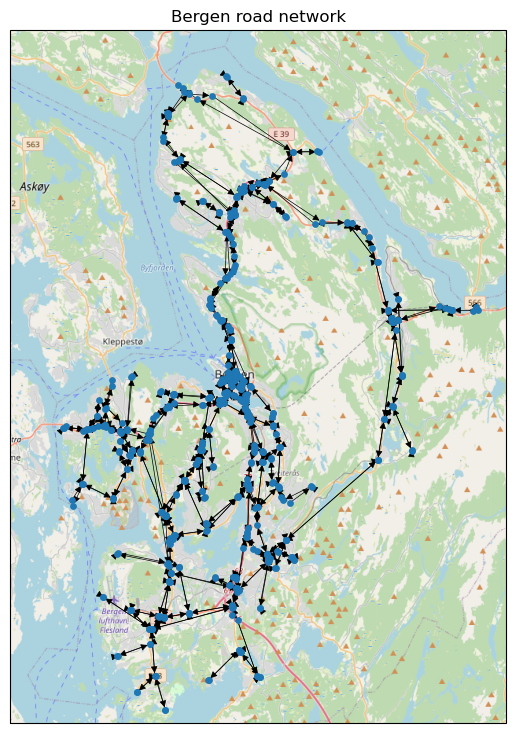

In [268]:
fig = plt.figure(figsize=(12,9)) # open matplotlib figure
ax = plt.axes(projection=osm_img.crs) # project using coordinate reference system (CRS) of street map

center_pt = [60.39299, 5.32415] # lat/lon of One World Trade Center in NYC
zoom = 0.15 # for zooming out of center point
extent = [center_pt[1]-(zoom*1.3),center_pt[1]+(zoom*1.6),center_pt[0]-zoom,center_pt[0]+zoom] # adjust to zoom
ax.set_extent(extent) # set extents

scale = np.ceil(-np.sqrt(2)*np.log(np.divide(zoom,350.0))) # empirical solve for scale based on zoom
scale = (scale<20) and scale or 19 # scale cannot be larger than 19
ax.add_image(osm_img, int(scale))

nx.draw_networkx(G, pos=pos, 
                 node_size=15,
                 ax=ax,
                 width=0.5,
                 arrows=True,
                 with_labels = False)

ax.set_title('Bergen road network')


In [269]:
for i in range(len(gdf.where(gdf["api_call_time"] == first_morning_date).dropna(how="all"))):
    p0 = gdf.where(gdf["api_call_time"] == first_morning_date).dropna(how="all").iloc[i][mapping["geometry.extreme_point"]][0]
    p1 = gdf.where(gdf["api_call_time"] == first_morning_date).dropna(how="all").iloc[i][mapping["geometry.extreme_point"]][1]
    t0 = tuple([p0.coords.xy[0][0], p0.coords.xy[1][0]])
    t1 = tuple([p1.coords.xy[0][0], p1.coords.xy[1][0]])
    if G.has_edge(t0, t1) and G.has_edge(t1, t0):
        ax.plot([t0[0], t1[0]], [t0[1], t1[1]], color="red", linewidth=1.5, transform=ccrs.Geodetic())

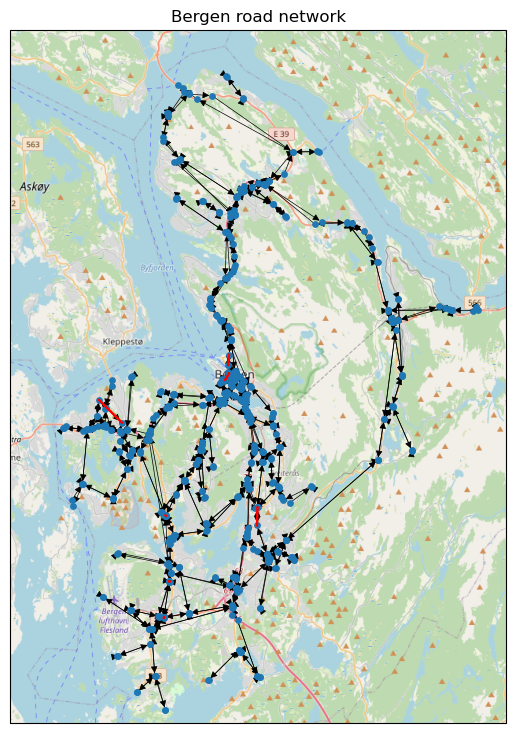

In [270]:
fig

In [278]:
nx.number_weakly_connected_components(G)

44

In [214]:
points = []
for ps in gdf.where(gdf["api_call_time"] == first_morning_date).dropna(how="all")["geometry.extreme_point"]:
    points.append(ps[0])
    points.append(ps[1])

In [260]:
gdf_points = gpd.GeoDataFrame(geometry=points)
gdf_points.crs = "EPSG:4326"

for i in range(len(gdf_points)):
    gdf_points = gdf_points.to_crs(epsg=4326)
    target_point_lat_lon = gdf_points.iloc[i].geometry
    gdf_points = gdf_points.to_crs(epsg=25832)
    target_point = gdf_points.iloc[i].geometry

    # compute distance between each point and target point
    gdf_points['distance'] = gdf_points.distance(target_point)

    
    # sort by distance and get the nearest point
    for j in range(len(gdf_points)):
        nearest_point = gdf_points.sort_values(by='distance').iloc[j].geometry
        nearest_point_lat_lon = gdf_points.sort_values(by='distance').to_crs(epsg=4326).iloc[j].geometry
        distance = gdf_points.sort_values(by='distance').iloc[j].distance
        if target_point != nearest_point:
            break
    
    if distance < 10:
        print(target_point_lat_lon, nearest_point_lat_lon, distance)

POINT (5.516120000000002 60.42207000000006) POINT (5.5160399999999985 60.422010000000014) 8.007482709304556
POINT (5.459970000000001 60.42193) POINT (5.460100000000001 60.421869999999984) 9.797458881351464
POINT (5.5160399999999985 60.422010000000014) POINT (5.5161200000000035 60.42207000000006) 8.007482709339117
POINT (5.456840000000001 60.37481) POINT (5.456989999999999 60.37478000000001) 8.925329427366151
POINT (5.456989999999999 60.37478000000001) POINT (5.456840000000001 60.37481) 8.925329427366151
POINT (5.253290000000006 60.28381999999999) POINT (5.25328 60.28384) 2.2962748600227885
POINT (5.25301 60.28388999999999) POINT (5.252940000000017 60.28385) 5.904826276835766
POINT (5.234690000000001 60.29210999999999) POINT (5.234750000000004 60.29203999999999) 8.476937684968684
POINT (5.234690000000001 60.29210999999999) POINT (5.234750000000004 60.29203999999999) 8.476937684968684
POINT (5.234750000000004 60.29203999999999) POINT (5.234690000000001 60.29210999999999) 8.47693768496868

KeyboardInterrupt: 